<a href="https://colab.research.google.com/github/lgvaz/faststyle/blob/master/examples/simple_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !nvidia-smi

In [0]:
# !pip install -q git+git://github.com/fastai/fastcore.git --upgrade
# !pip install -q git+git://github.com/fastai/fastai2.git --upgrade
# !pip install -q git+git://github.com/lgvaz/faststyle.git

In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from faststyle import *

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')
save_dir = root_dir/'dl/faststyle'; save_dir.mkdir(exist_ok=True, parents=True)
# save_dir = Path('.')

Mounted at /content/gdrive


In [0]:
source = untar_data(URLs.COCO_SAMPLE)

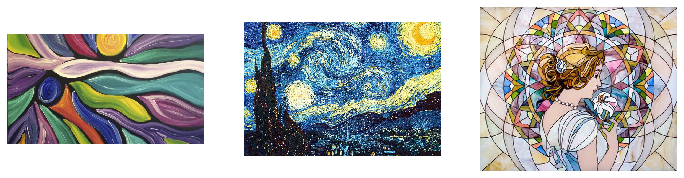

In [7]:
# Fix styles for colab
style_dir = Path('styles')
style_fns = L('abstract.jpg', 'starry_night.jpg', 'mosaic.jpg')
style_fns = style_fns.map(lambda o: style_dir/o)
show_images([PILImage.create(fn) for fn in style_fns])

In [0]:
dblock = DataBlock(style_blocks, get_items=get_image_files, splitter=RandomSplitter(.1),
                   item_tfms=[Resize(400)],
                   batch_tfms=[*aug_transforms(), NormalizeX.from_stats(*coco_stats)])

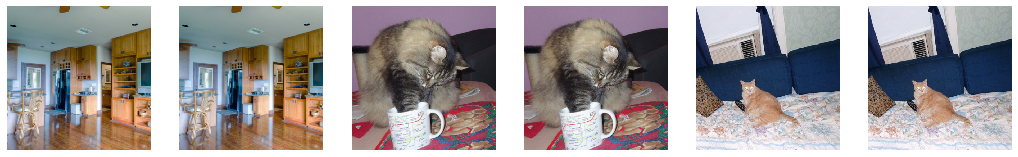

In [9]:
dls = dblock.dataloaders(source, bs=8); dls.c = 3
dls.show_batch(rows=1, max_n=3)

In [0]:
get_feats = LayerFeats.from_feat_m(FeatModels.vgg19)

In [0]:
cbs = [SaveModelCallback(), FeatsCallback.from_fns(style_fns, get_feats)]
loss_func = FastStyleLoss(stl_w=5e5, tv_w=1000)
metrics = loss_func.metrics
cfg = unet_config(blur=True, self_attention=True, norm_type=NormType.Weight, y_range=(0.,1.))
learn = unet_learner(dls=dls, arch=resnet34, loss_func=loss_func, cbs=cbs,
                     metrics=metrics, config=cfg)

In [0]:
learn.path = save_dir

(0.0003019951749593019, 0.009120108559727669)

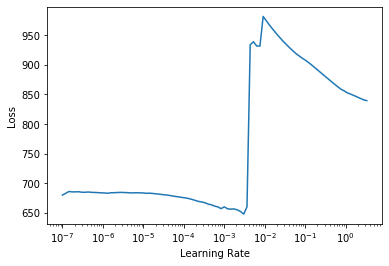

In [12]:
# learn.lr_find()

In [13]:
learn.fit_one_cycle(1, 1e-3, pct_start=.9)

epoch,train_loss,valid_loss,stl,cnt,tv,time
0,53.389698,54.584568,12.813502,13.749849,28.021204,1:22:04


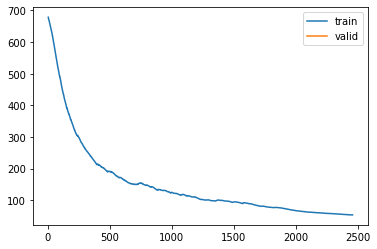

In [15]:
learn.recorder.plot_loss()

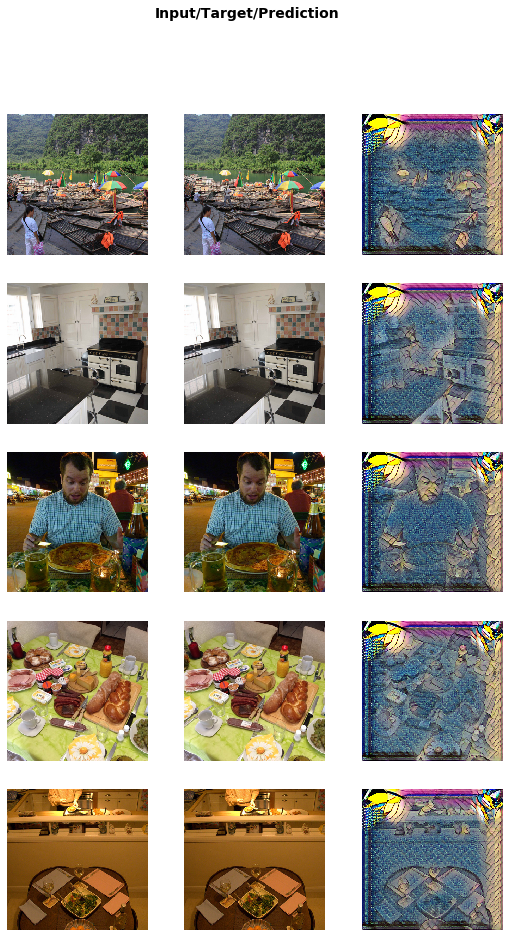

In [15]:
learn.show_results()

In [0]:
learn.save('unet-abstract-starry-mosaic-512')